In [1]:
# Here we take care of paths.

from pathlib import Path
import os
print('Starting path:' + os.getcwd())
if os.getcwd()[-16:] == 'image-to-tex-OCR':
    pass
else:
    PATH = Path().resolve().parents[0]
    os.chdir(PATH)

# make sure you are in Paragraph_to_Tex folder
print('Current path:' + os.getcwd())

Starting path:/Users/gregory/PROJECT_ML/PROJECT_AMINE/image-to-tex-OCR/Jupyter_Notebooks
Current path:/Users/gregory/PROJECT_ML/PROJECT_AMINE/image-to-tex-OCR


In [2]:
from Data.Data_Module import Data_Module
from Models.Printed_Tex_Transformer import ResNetTransformer
from Lightning_Models.Printed_Tex_Lit_Model import LitResNetTransformer
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from PIL import Image
import torch
from pytorch_lightning.loggers import TensorBoardLogger
from torchvision import transforms
from PIL import Image
from IPython.display import display, Math
from Data.image_transforms import Image_Transforms
import cv2
import cv2
import PIL
import numpy as np
transform = transforms.ToPILImage()



dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


In [3]:
# Generate Data Module by uploading images and formulas
# images need to be in the folder Data/Data_Bank/generated_png_images
# formulas need to be in Data/Data_Bank/final_png_formulas.txt
# image filenames need to be in Data/Data_Bank/corresponding_png_images.txt

dataset = Data_Module(stage = 'fit',
                 set_max_label_length = 150,
                 number_png_images_to_use_in_dataset=250*1000,
                 labels_transform='default',
                image_transform_name ='alb',
                 train_val_fraction = 0.999,
                   vocabulary_path = 'Tokenizer/230k_ver2.json',
                load_vocabulary = True,
                      image_padding = True,
                      max_width = 10*1000,


                 batch_size = 128,
                num_workers = 8,
                data_on_gpu = True,
                )

In [4]:
print( 
    'Vocabulary size:',len(dataset.vocabulary),
    '\nMax label length:', dataset.max_label_length,
    "\nStart <S> goes to index ",dataset.vocabulary['<S>'],
      "\nEnd <E> goes to index ",dataset.vocabulary['<E>'],
      "\nPadding <P> goes to index ",dataset.vocabulary['<P>'],
)

Vocabulary size: 581 
Max label length: 152 
Start <S> goes to index  0 
End <E> goes to index  1 
Padding <P> goes to index  2


In [5]:


# HELPER FUNCTIONS
def token_to_strings(tokens):
    mapping = dataset.vocabulary
    inverse_mapping =dataset.inverse_vocabulary
    s=''
    if tokens.shape[0] ==1:
        tokens = tokens[0]
    for number in tokens:
        letter = inverse_mapping[number.item()]
        s= s +" " + str(letter)
    return s

In [16]:
model = ResNetTransformer(dataset=dataset).to(dev)
model.load_state_dict(torch.load(("Models_Parameters_Log/Inverted_150seq_128Height_256embed_resnet18_4layers_8ratio_inverted_2.pth"), map_location=torch.device('cpu')))
lit_model = LitResNetTransformer(model=model, WandB=False)
lit_model.eval()
lit_model.freeze()
scripted_save = lit_model.to_torchscript()
torch.jit.save(scripted_save, "Models_Parameters_Log/scripted_model1.pt")


In [7]:
scripted = torch.jit.load("Models_Parameters_Log/scripted_model1.pt")

In [8]:
import albumentations
from albumentations.augmentations.geometric.resize import Resize
import torch.nn.functional as F

MAX_RATIO = 8
GOAL_HEIGHT = 128

    


def predict(image_path):
   
    image = Image.open(image_path).convert('RGB')
    image = np.asarray(image)
    #image = cv2.bitwise_not(image)
    h, w, c = image.shape
    ratio =w / h
    if ratio == 0:
        ratio = 1 
    if ratio > MAX_RATIO:
        ratio = MAX_RATIO
        
    new_h = GOAL_HEIGHT
    new_w = int(new_h * ratio)
    image = Resize(interpolation= cv2.INTER_LINEAR,height=new_h, width= new_w, always_apply=True)(image=image)['image']
    print(image.shape)


    
    image_tensor = Image_Transforms.test_transform_with_padding(image =np.array(image))['image'][:1]
    print(display(transform(image_tensor)))
    
    max_H = 128
    max_W = 1024

    image_tensor = F.pad(image_tensor, (0, max_W - new_w, 0, max_H - new_h), value=0)

    
    print(image_tensor.shape)
    print(display(transform(image_tensor)))
    print('\nPredicted formula:')
    prediction =  scripted(image_tensor.unsqueeze(0))
    print(token_to_strings(prediction))
    print(display(Math(token_to_strings(prediction))))



def predict_inverted(image_path):
   
    image = Image.open(image_path).convert('RGB')
    image = np.asarray(image)
    h, w, c = image.shape
    image = cv2.bitwise_not(image)
    
    ratio =w / h
    if ratio == 0:
        ratio = 1 
    if ratio > MAX_RATIO:
        ratio = MAX_RATIO
        
    new_h = GOAL_HEIGHT
    new_w = int(new_h * ratio)
    image = Resize(interpolation= cv2.INTER_LINEAR,height=new_h, width= new_w, always_apply=True)(image=image)['image']
    print(image.shape)


    
    image_tensor = Image_Transforms.test_transform_with_padding(image =np.array(image))['image'][:1]
    print(display(transform(image_tensor)))
    
    max_H = 128
    max_W = 1024

    image_tensor = F.pad(image_tensor, (0, max_W - new_w, 0, max_H - new_h), value=0)

    
    print(image_tensor.shape)
    print(display(transform(image_tensor)))
    print('\nPredicted formula:')
    prediction =  scripted(image_tensor.unsqueeze(0))
    print(token_to_strings(prediction))
    print(display(Math(token_to_strings(prediction))))

    
    
    
def predict_simple(image_path):
   
    image = Image.open(image_path).convert('RGB')
    image = np.asarray(image)
    h, w, c = image.shape
    #ratio =w / h
    #if ratio == 0:
        #ratio = 1 
    #if ratio > MAX_RATIO:
        #ratio = MAX_RATIO
        ##new_h = GOAL_HEIGHT
        #new_w = int(new_h * ratio)
        #image = Resize(interpolation= cv2.INTER_LINEAR,height=new_h, width= new_w, always_apply=True)(image=image)['image']
    
    print(image.shape)


    
    image_tensor = Image_Transforms.test_transform_with_padding(image =np.array(image))['image']#[:1]
    print(display(transform(image_tensor)))
    
    print(image_tensor.shape)
    print('\nPredicted formula:')
    prediction =  scripted(image_tensor.unsqueeze(0))
    print(token_to_strings(prediction))
    print(display(Math(token_to_strings(prediction))))

    
    
    
    
    
def predict_scaled(image_path):
    image = Image.open(image_path).convert('RGB')
    image = np.asarray(image)
    h, w, c = image.shape
    ascpect = w/h
    if ascpect == 0:
        ascpect = 1 
    if ascpect > MAX_RATIO:
        ascpect = MAX_RATIO
    
    downscale = GOAL_HEIGHT/h
    image = cv2.resize(image, (0,0), fx=downscale, fy=downscale,interpolation=cv2.INTER_LINEAR)
   
    print(image.shape)
    



    
    image_tensor = Image_Transforms.test_transform_with_padding(image =np.array(image))['image'][:1]
    max_H = 128
    max_W = 1024

    if h<128 and w<1024:
        image_tensor = F.pad(image_tensor, (0, max_W - w, 0, max_H - h), value=0)

    print(display(transform(image_tensor)))
    print(image_tensor.shape)
    print('\nPredicted formula:')
    prediction =  scripted(image_tensor.unsqueeze(0))
    print(token_to_strings(prediction))
    print(display(Math(token_to_strings(prediction))))

    
# HELPER FUNCTIONS
def token_to_strings(tokens):
    mapping = dataset.vocabulary
    inverse_mapping =dataset.inverse_vocabulary
    s=''
    if tokens.shape[0] ==1:
        tokens = tokens[0]
    for number in tokens:
        letter = inverse_mapping[number.item()]
        s= s +" " + str(letter)
    return s
    

In [9]:
IMAGES= [#'Jupyter_Notebooks/test_photos/79a37d9d8b727e9.png',
         "Jupyter_Notebooks/test_photos/0a0df4c4229b725.png",
         "Jupyter_Notebooks/test_photos/zarhin.png",
         "Jupyter_Notebooks/test_photos/my_image.png",
         "Jupyter_Notebooks/test_photos/screenshot_1.png",
         "Jupyter_Notebooks/test_photos/screenshot_3.png",
         "Jupyter_Notebooks/test_photos/Screen Shot_14.png",
         "Jupyter_Notebooks/test_photos/Screen Shot_10.png",
         "Jupyter_Notebooks/test_photos/Screen Shot_13.png",
          "Jupyter_Notebooks/test_photos/Screen Shot_11.png",
         "Jupyter_Notebooks/test_photos/screenshot_2.png",
         "Jupyter_Notebooks/test_photos/Screen Shot_18.png",
        'Jupyter_Notebooks/test_photos/128.png',
         'Jupyter_Notebooks/test_photos/128_2.png',
         'Jupyter_Notebooks/test_photos/image_3.png',
         'Jupyter_Notebooks/test_photos/Screen Shot_15.png',
         'Jupyter_Notebooks/test_photos/Screen Shot_11.png',
         'Jupyter_Notebooks/test_photos/Screen Shot_16.png',
         'Jupyter_Notebooks/test_photos/Screen Shot_17.png',
         'Jupyter_Notebooks/test_photos/screenshot_2.png',
         'Jupyter_Notebooks/test_photos/ratio25.png',
         'Jupyter_Notebooks/test_photos/ratio31.png',
        'Jupyter_Notebooks/test_photos/ratio76.png',
         
    

]

(128, 555, 3)


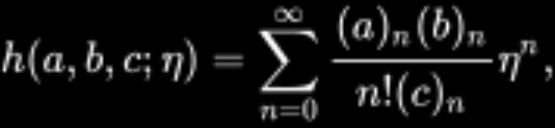

None
torch.Size([1, 128, 1024])


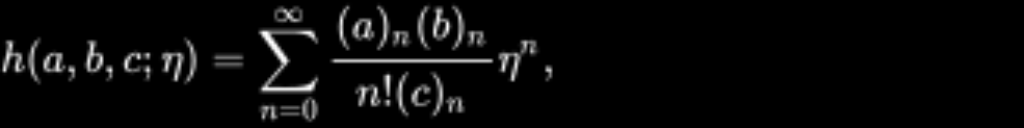

None

Predicted formula:
 <S> h \langle a , b , \, c ; \, \eta \rangle = \sum _ { v = 0 } ^ { \infty } \frac { ( a ) _ { v } ( b ) _ { v } } { n ! ( e ) _ { v } } \eta ^ { r } , <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 569, 3)


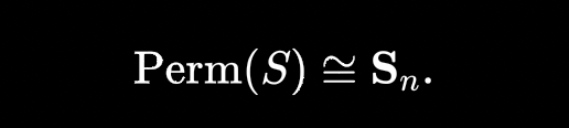

None
torch.Size([1, 128, 1024])


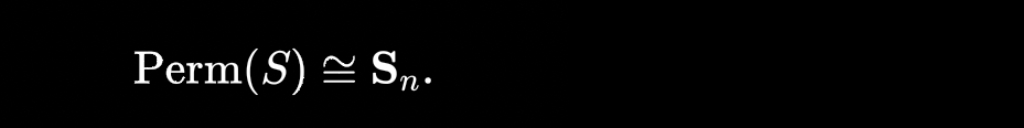

None

Predicted formula:
 <S> \mathrm { P e r m } ( S ) \cong { \bf S } _ { n } . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 484, 3)


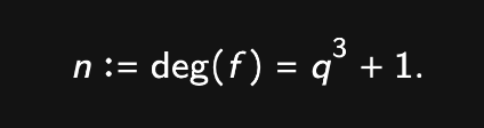

None
torch.Size([1, 128, 1024])


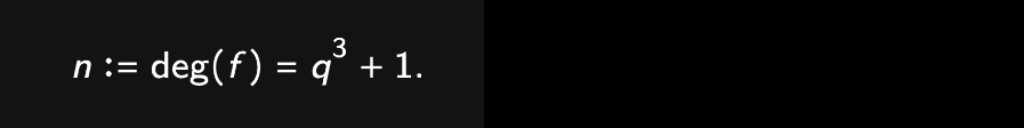

None

Predicted formula:
 <S> n : = \mathrm { d e g } ( f ) \, = \, q ^ { 3 } + 1 . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 554, 3)


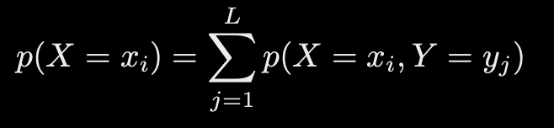

None
torch.Size([1, 128, 1024])


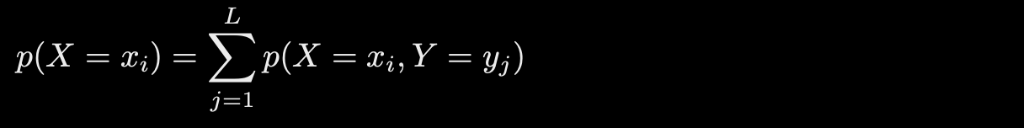

None

Predicted formula:
 <S> p ( X = x _ { i } ) = \sum _ { j = 1 } ^ { L } p ( X = x _ { i } , Y = y _ { j } ) <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 432, 3)


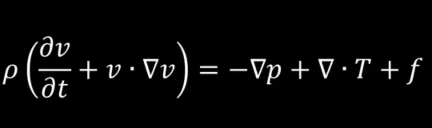

None
torch.Size([1, 128, 1024])


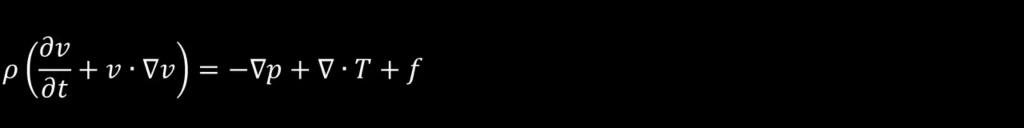

None

Predicted formula:
 <S> \rho \left( \frac { \partial v } { \partial t } + v \cdot \nabla v \right) = - \nabla p + \nabla \cdot T + f <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 911, 3)


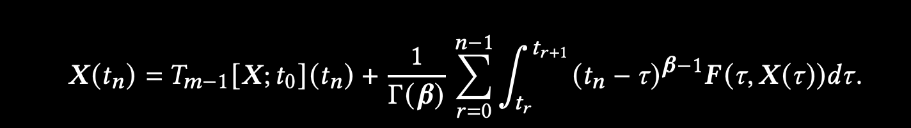

None
torch.Size([1, 128, 1024])


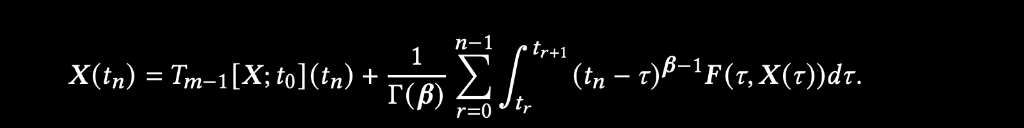

None

Predicted formula:
 <S> X ( t _ { n } ) = T _ { m - 1 } [ X ; t _ { 0 } ] ( t _ { n } ) + \frac { 1 } { \Gamma ( \beta ) } \sum _ { r = 0 } ^ { n - 1 } \int _ { t _ { r } } ^ { t _ { r + 1 } } ( t _ { n } - \tau ) ^ { \beta - 1 } F ( \tau , X ( \tau ) ) d \tau . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 1024, 3)


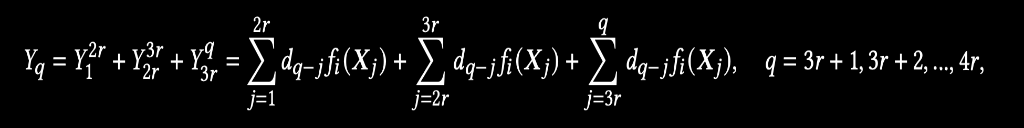

None
torch.Size([1, 128, 1024])


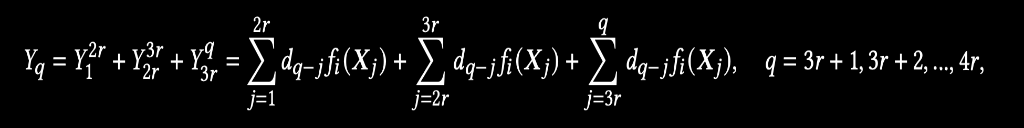

None

Predicted formula:
 <S> Y _ { q } = Y _ { 1 } ^ { 2 r } + Y _ { 2 r } ^ { 3 r } + Y _ { 3 r } ^ { q } = \sum _ { j = 1 } ^ { 2 r } d _ { q - j f i } ( X _ { j } ) + \sum _ { j = 2 r } ^ { 3 r } d _ { q - j f i } ( X _ { j } ) + \sum _ { j = 3 r } ^ { q } d _ { q - j f i } ( X _ { j } ) , \quad q = 3 r + 1 , 3 r + 2 , . . 4 r , <E> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 1024, 3)


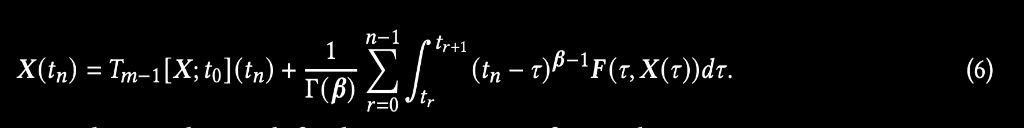

None
torch.Size([1, 128, 1024])


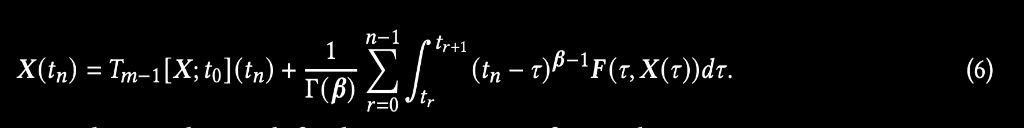

None

Predicted formula:
 <S> X ( t _ { n } ) = T _ { m - 1 } [ X ; t _ { 0 } ] ( t _ { n } ) + \frac { 1 } { \Gamma ( \beta ) } \sum _ { r = 0 } ^ { n - 1 } \int _ { t _ { r } } ^ { t _ { r + 1 } } ( t _ { n } - \tau ) ^ { \beta - 1 } F ( \tau , X ( \tau ) ) d \tau . \tag { 6 } <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 270, 3)


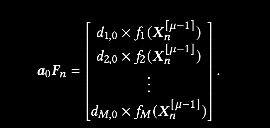

None
torch.Size([1, 128, 1024])


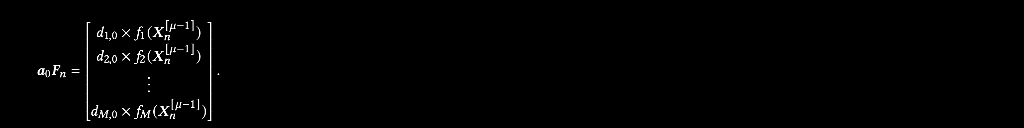

None

Predicted formula:
 <S> a _ { i } F _ { i } = \left[ \begin{array} { c } { d _ { i j } \times K _ { i j } ^ { i j - 1 } } \\ { d _ { i j } \times K _ { i j } ^ { i j - 1 } } \\ { d _ { i j } \times K _ { i j } ^ { i j - 1 } } \\ { d _ { i j } \times K _ { i j } ^ { i j - 1 } ) } \\ \end{array} \right] . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 582, 3)


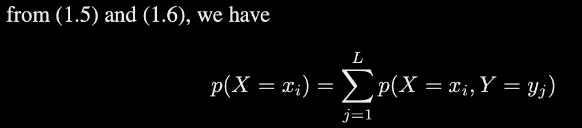

None
torch.Size([1, 128, 1024])


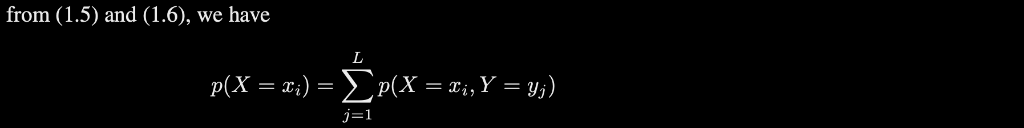

None

Predicted formula:
 <S> \begin{array} { l l } { \mathrm { f o m ~ ( 1 , 5 ) ~ a n d ~ } ( 1 , 5 ) , ~ w e ~ } } \\ { p ( X = x _ { i } ) = \sum _ { j = 1 } ^ { L } p ( X = x _ { i } , Y = y _ { j } ) } \\ \end{array} <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 768, 3)


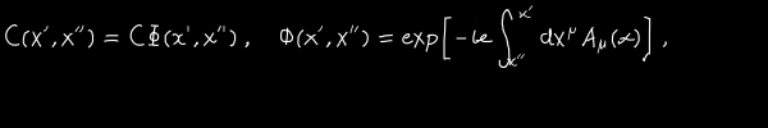

None
torch.Size([1, 128, 1024])


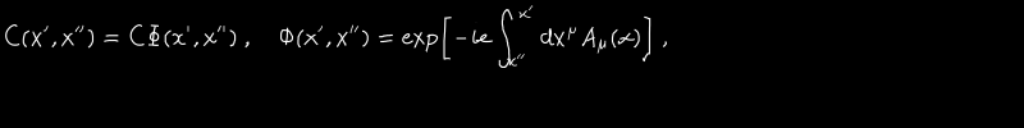

None

Predicted formula:
 <S> \zeta _ { C } \chi ^ { \prime } \star \chi ^ { \prime } ) = \zeta \Phi ( \chi ^ { * } \star \chi ^ { \prime } ) \, , \quad { \bf Q } ( \chi ^ { * } \star \chi ^ { \prime } ) \, = \, \omega \chi _ { P } \Bigl [ - \omega \sum _ { A } ^ { * } \mathrm { d } \chi ^ { * } \wedge A _ { \mu } ( \varphi ) \Bigr ] \, . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 228, 3)


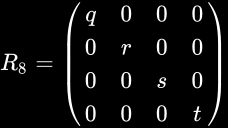

None
torch.Size([1, 128, 1024])


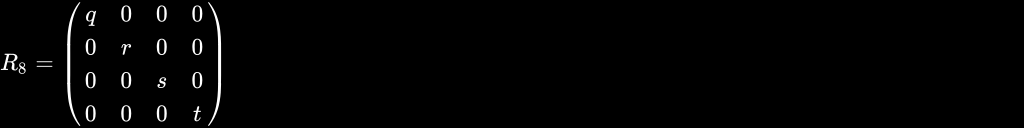

None

Predicted formula:
 <S> R _ { 8 } = \left( \begin{array} { c c c c } { q } & { 0 } & { 0 } \\ { 0 } & { r } & { 0 } & { 0 } \\ { 0 } & { 0 } & { s } & { 0 } \\ { 0 } & { 0 } & { 0 } & { t } \\ \end{array} \right) <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 1024, 3)


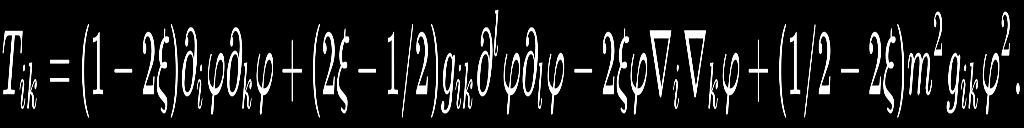

None
torch.Size([1, 128, 1024])


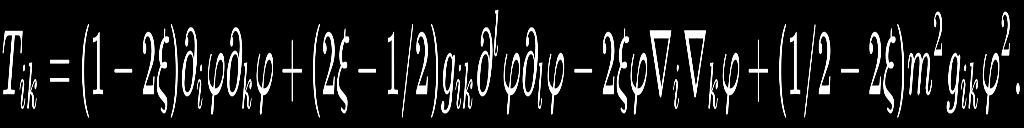

None

Predicted formula:
 <S> T _ { i k } = ( 1 - 2 \xi ) \partial _ { i } \varphi \partial _ { k } \varphi + ( 2 \xi - 1 / 2 ) g _ { i k } \partial ^ { i } \varphi \partial _ { l } \varphi - 2 \xi \varphi \nabla _ { i } \nabla _ { k } \varphi + ( 1 / 2 - 2 \xi ) m ^ { 2 } g _ { i k } \varphi ^ { 2 } . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 727, 3)


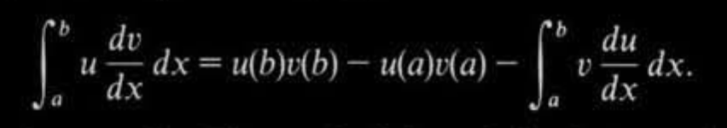

None
torch.Size([1, 128, 1024])


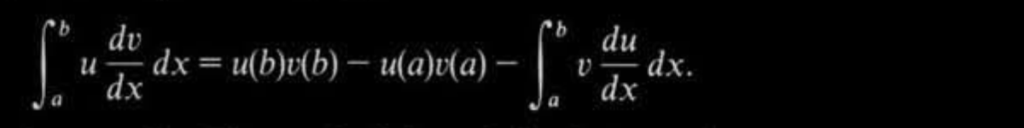

None

Predicted formula:
 <S> \int _ { a } ^ { b } u \frac { d v } { d \chi } \, d \chi = u ( b \hat { v } ( b ) - u ( d ) v ( \hat { u } ) - \int _ { a } ^ { b } v \frac { d u } { d \chi } d \chi . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 949, 3)


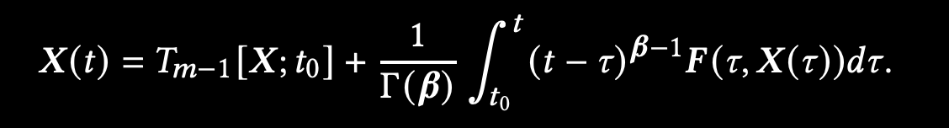

None
torch.Size([1, 128, 1024])


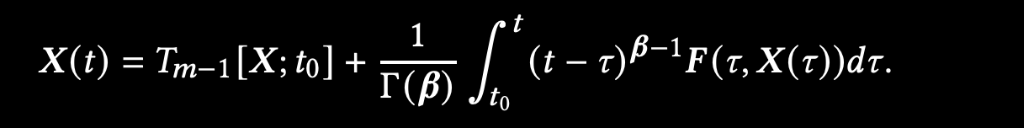

None

Predicted formula:
 <S> X ( t ) = T _ { m - 1 } [ X ; t _ { 0 } ] + \frac { 1 } { \Gamma ( \beta ) } \int _ { t _ { 0 } } ^ { t } ( t - \tau ) ^ { \beta - 1 } F ( \tau , X ( \tau ) ) d \tau . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 270, 3)


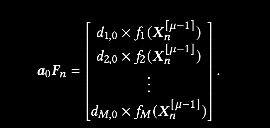

None
torch.Size([1, 128, 1024])


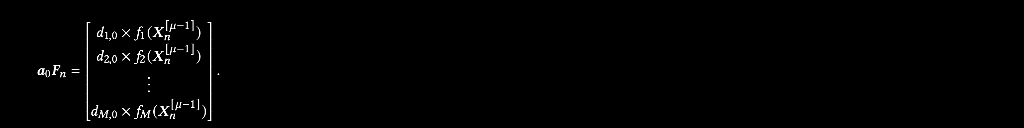

None

Predicted formula:
 <S> a _ { i } F _ { i } = \left[ \begin{array} { c } { d _ { i j } \times K _ { i j } ^ { i j - 1 } } \\ { d _ { i j } \times K _ { i j } ^ { i j - 1 } } \\ { d _ { i j } \times K _ { i j } ^ { i j - 1 } } \\ { d _ { i j } \times K _ { i j } ^ { i j - 1 } ) } \\ \end{array} \right] . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 768, 3)


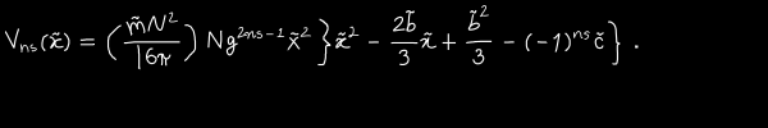

None
torch.Size([1, 128, 1024])


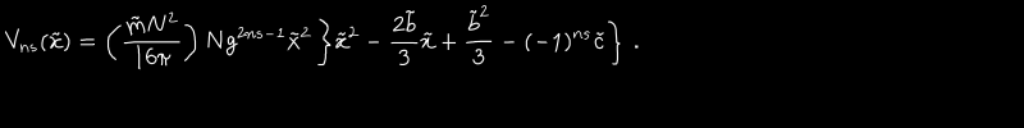

None

Predicted formula:
 <S> \chi _ { \gamma _ { \infty } } ( { \tilde { \cal K } } ) = \left( \begin{matrix} { { \tilde { \Gamma } } \lambda ^ { 2 \gamma _ { 2 } - 1 } { \tilde { \kappa } } ^ { 2 } } \right\} { \tilde { \cal K } } ^ { 2 } - \frac { 2 5 } { 2 } { \tilde { \chi } } + \frac { { E } ^ { 2 } } { 3 } - ( - t ) ^ { \gamma _ { 8 } } { \tilde { \chi } } } \\ \end{matrix} \right) \, . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 768, 3)


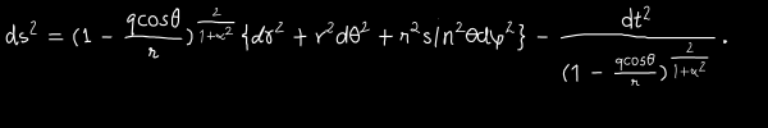

None
torch.Size([1, 128, 1024])


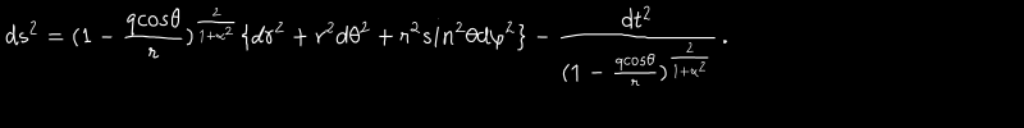

None

Predicted formula:
 <S> \mathrm { d z } ^ { 2 } = \langle 1 - \frac { 4 \infty s \oint \frac { d z } { 2 } \sqrt { \frac { d z \omega ^ { 2 } } { i + \omega ^ { 2 } } } \, \langle \phi G ^ { 2 } + \gamma ^ { 2 } \mathrm { s } \zeta h \varphi ^ { 2 } \} - \frac { \mathrm { e t } ^ { 2 } } { \sqrt { 1 + \omega ^ { 2 } } } } \, . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 582, 3)


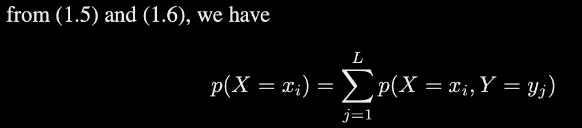

None
torch.Size([1, 128, 1024])


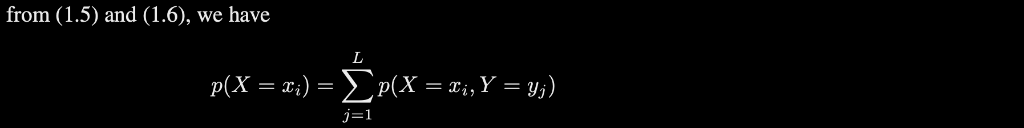

None

Predicted formula:
 <S> \begin{array} { l l } { \mathrm { f o m ~ ( 1 , 5 ) ~ a n d ~ } ( 1 , 5 ) , ~ w e ~ } } \\ { p ( X = x _ { i } ) = \sum _ { j = 1 } ^ { L } p ( X = x _ { i } , Y = y _ { j } ) } \\ \end{array} <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 1024, 3)


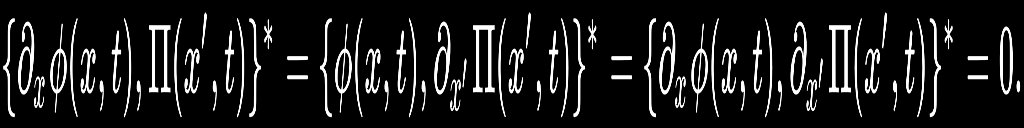

None
torch.Size([1, 128, 1024])


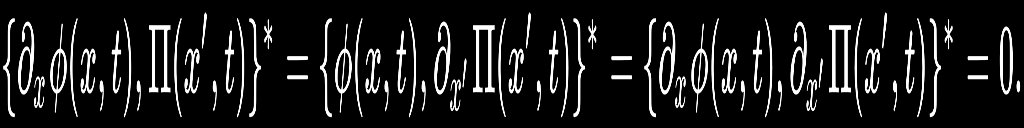

None

Predicted formula:
 <S> \{ \partial _ { x } \phi ( x , t ) , \Pi ( x ^ { \prime } , t ) \} ^ { * } = \{ \phi ( x , t ) , \partial _ { x ^ { \prime } } \Pi ( x ^ { \prime } , t ) \} ^ { * } = \{ \partial _ { x } \phi ( x , t ) , \partial _ { x ^ { \prime } } \Pi ( x ^ { \prime } , t ) \} ^ { * } = 0 . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 1024, 3)


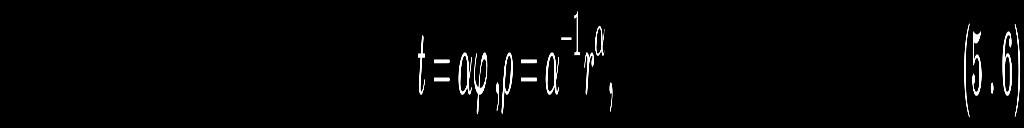

None
torch.Size([1, 128, 1024])


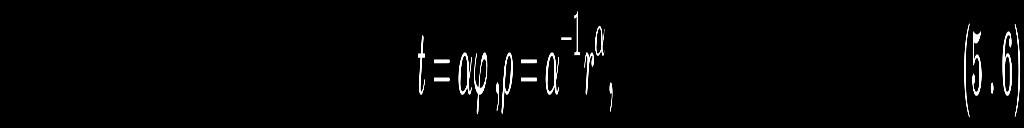

None

Predicted formula:
 <S> t = \alpha \varphi \ , \rho = \alpha ^ { - 1 } r ^ { \alpha } , \tag { 5 . 6 } <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 1024, 3)


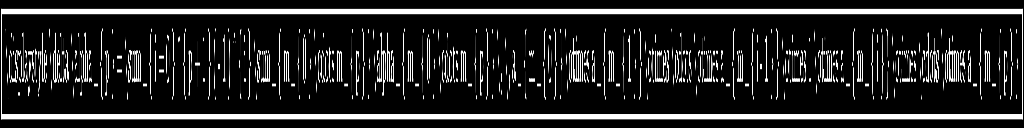

None
torch.Size([1, 128, 1024])


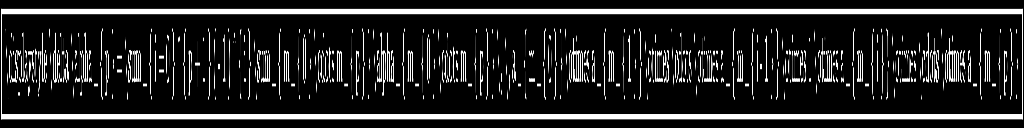

None

Predicted formula:
 <S> \fbox { { \psi _ { 1 } } = 0 , \quad \psi _ { 1 } ^ { \prime } , \quad \psi _ { 2 } = \psi _ { 1 } ^ { \prime } , \quad \psi _ { 2 } ^ { \prime } , \quad \psi _ { 1 } ^ { \prime } , \quad \psi _ { 2 } ^ { \prime } , \quad \psi _ { 1 } ^ { \prime } , \psi _ { 2 } , \psi _ { 2 } , \psi _ { 1 } , \psi _ { 2 } , \psi _ { 2 } , \psi _ { 1 } , \psi _ { 2 } , \psi _ { 1 } , \psi _ { 2 } , \psi _ { 2 } , <E> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


In [10]:
for image in IMAGES:
    predict(image)

(41, 178, 3)


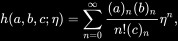

None
torch.Size([3, 41, 178])

Predicted formula:
 <S> h ( a , b , c , \eta ) = \sum _ { i ( a , b , c , \eta ) = \sum _ { i , b , c , \eta = \sum _ { i , b , b , c , \eta = \sum _ { i , b , b , b , b , b } ^ { i b , b , b , b , b = \sum _ { i , b , b , b , b , b } \frac { b , b , b , b , b = \sum _ { i b , b , b , b , b , b , b , b = b , b , c , b , b , b , b , b , b , b , b , b , b , b


<IPython.core.display.Math object>

None
(116, 516, 3)


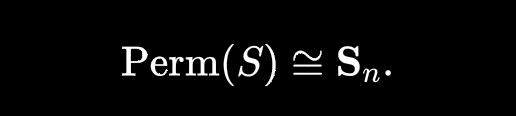

None
torch.Size([3, 116, 516])

Predicted formula:
 <S> \mathrm { P e r m } ( S ) \cong { \bf S } _ { n } . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(112, 424, 3)


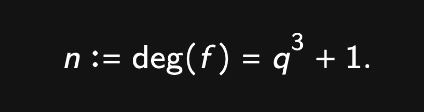

None
torch.Size([3, 112, 424])

Predicted formula:
 <S> n : = \mathrm { d e g } ( f ) = \, q ^ { 3 } + 1 . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(152, 658, 3)


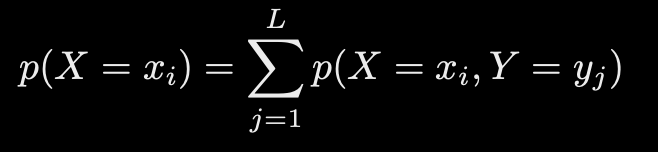

None
torch.Size([3, 152, 658])

Predicted formula:
 <S> p ( X = x _ { i } ) = \sum _ { j = 1 } ^ { L } p ( X = x _ { i } , Y = y _ { j } ) <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(320, 1080, 3)


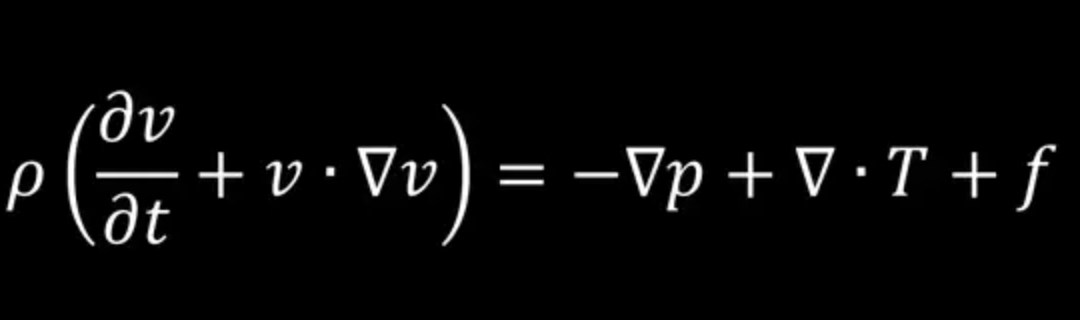

None
torch.Size([3, 320, 1080])

Predicted formula:
 <S> \rho \left( \frac { \partial v } { \partial t } + v \cdot \nabla v \right) = - \nabla p + \nabla \cdot T + F \cdot T \cdot F <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(200, 1424, 3)


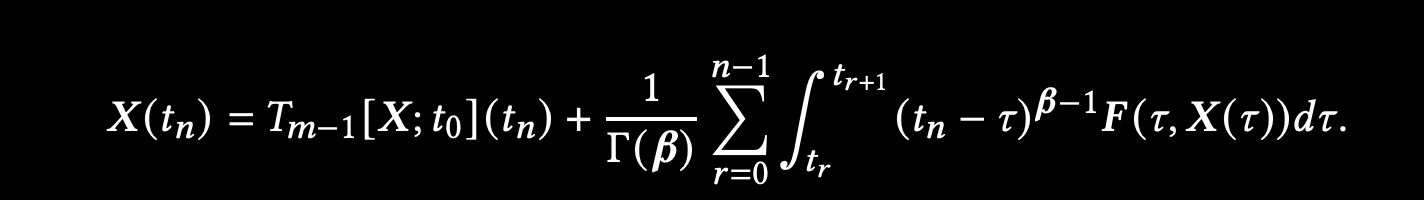

None
torch.Size([3, 200, 1424])

Predicted formula:
 <S> \begin{array} { c c c } { X ( t _ { n } ) = T _ { m - 1 } [ X ; t _ { 0 } ] ( t _ { n } ) + \frac { 1 } { \Gamma ( \theta ) } \sum _ { r = 0 } ^ { n - 1 } \int _ { t _ { r } } ^ { n + 1 } ( t _ { n } - \tau ) ^ { \beta - 1 } ( t _ { n } - \tau ) ^ { \beta - 1 } ( t _ { n } - \tau ) ^ { \beta - 1 } ( t _ { n } - \tau ) ^ { \beta - 1 } ( t _ { n } ) } \\ \end{array} <E> <P> <P>


<IPython.core.display.Math object>

None
(188, 1950, 3)


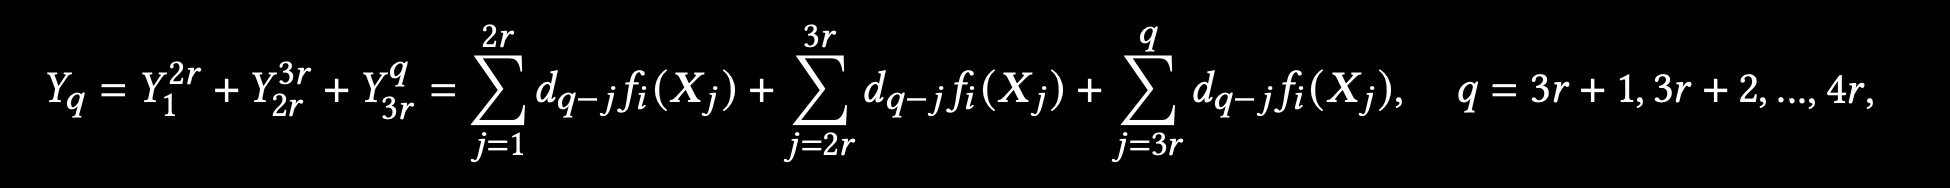

None
torch.Size([3, 188, 1950])

Predicted formula:
 <S> Y _ { q } = Y _ { 1 } ^ { 2 r } + Y _ { 2 r } ^ { 3 r } + Y _ { 3 r } ^ { q } = \sum _ { j = 1 } ^ { 2 r } d _ { q - j f i } ( X _ { j } ) + \sum _ { j = 2 r } ^ { 3 r } d _ { q - j f i } ( X _ { j } ) + \sum _ { j = 2 r } . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(202, 1774, 3)


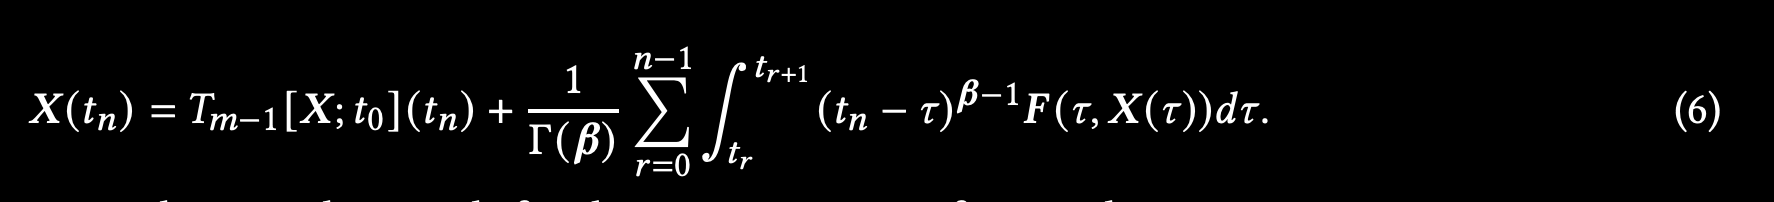

None
torch.Size([3, 202, 1774])

Predicted formula:
 <S> \begin{array} { c c c } { X ( t _ { n } ) = T _ { m - 1 } [ X ; t _ { 0 } ] ( t _ { n } ) + \frac { 1 } { \Gamma ( \beta ) } \sum _ { r = 0 } ^ { n - 1 } \int _ { t _ { r } } ^ { t _ { r + 1 } } ( t _ { n } - \tau ) ^ { \beta - 1 } F ( t _ { n } - \tau ) ^ { \beta - 1 } F ( t _ { n } - \tau ) ^ { \beta - 1 } F _ { r } . } \\ \end{array} <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(384, 812, 3)


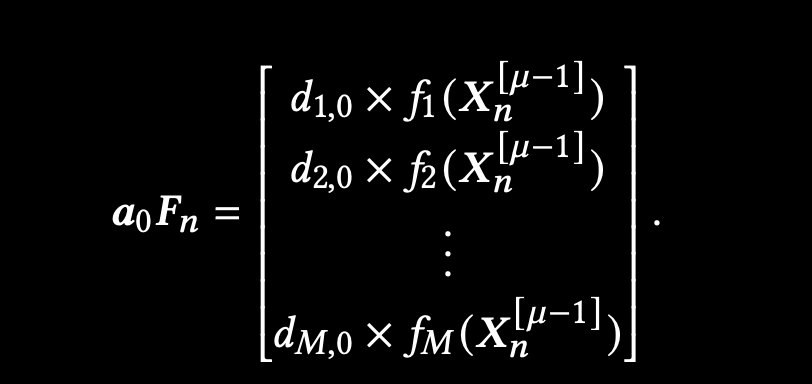

None
torch.Size([3, 384, 812])

Predicted formula:
 <S> \begin{array} { c c c } { a _ { 0 } F _ { n } = } \\ { d _ { 2 , 0 } \times f _ { 2 } ( X _ { n } ^ { [ \mu - 1 ] } ) } \\ \end{array} <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(224, 1020, 3)


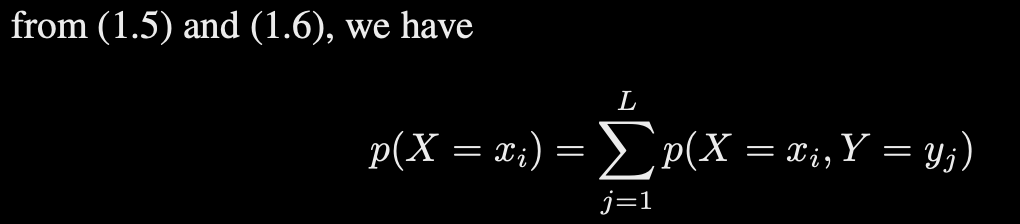

None
torch.Size([3, 224, 1020])

Predicted formula:
 <S> \mathrm { f r o m } \left( 1 , \Im \right) \mathrm { a n d } \left( 1 , 0 \right) , \mathrm { w e ~ h a v e } } <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(100, 600, 3)


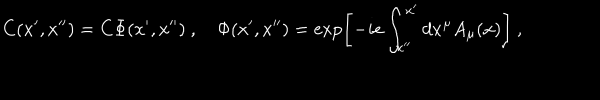

None
torch.Size([3, 100, 600])

Predicted formula:
 <S> \begin{array} { c c c } { \zeta _ { ( \zeta , \zeta ^ { \prime } ) } & { } & { } & { \Theta ( \zeta ^ { \prime } , \zeta ^ { \prime } ) : } & { \Theta ( \zeta ^ { \prime } , \zeta ^ { \prime } ) : } & { \Theta ( \zeta ^ { \prime } , \zeta ^ { \prime } ) : } \\ { \cdots , \cdots , \cdots , \cdots , \cdots , \cdots , \cdots , \cdots , \cdots , \cdots , \cdots , \cdots , \cdots , \cdots , } \\ \end{array} <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 228, 3)


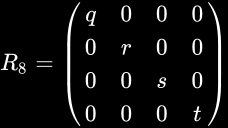

None
torch.Size([3, 128, 228])

Predicted formula:
 <S> R _ { 8 } = \left( \begin{array} { c c c c c } { q } & { 0 } & { 0 } & { 0 } \\ { 0 } & { r } & { 0 } & { 0 } \\ { 0 } & { 0 } & { s } & { 0 } \\ { 0 } & { 0 } & { s } & { 0 } \\ { 0 } & { 0 } & { 0 } & { t } \\ \end{array} \right) } \\ { 0 } & { 0 } & { 0 } & { t } \\ \end{array} \right) <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 3260, 3)


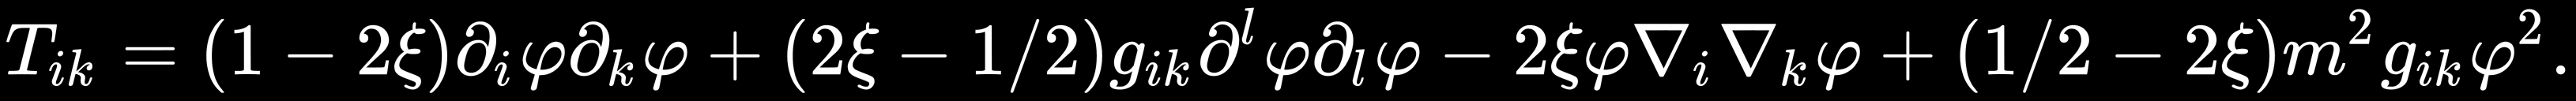

None
torch.Size([3, 128, 3260])

Predicted formula:
 <S> T _ { i k } = ( 1 - 2 \xi ) \partial _ { i } \varphi \partial _ { k } \varphi + ( 2 \xi + ( 2 \xi + ( 2 \xi + ) <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(150, 852, 3)


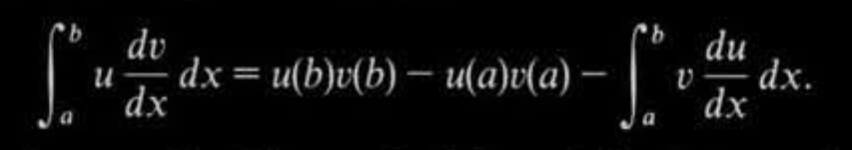

None
torch.Size([3, 150, 852])

Predicted formula:
 <S> { \bf J } _ { a } ^ { b } u \frac { \vec { d } v } { d \chi } d \chi = u ( b \vec { b } \vec { \psi } ) + u ( \vec { a } ) v ( \vec { a } ) - \int _ { a } ^ { b } v \frac { \vec { d } u } { d \chi } d \chi _ { a } . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(152, 1128, 3)


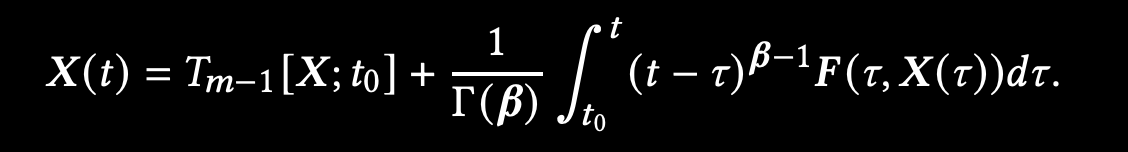

None
torch.Size([3, 152, 1128])

Predicted formula:
 <S> X ( t ) = T _ { m - 1 } [ X ; t _ { 0 } ] + \frac { 1 } { \Gamma ( \beta ) } \int _ { t _ { 0 } } ^ { t } ( t - \tau ) ^ { \beta - 1 } F ( \tau , X ( \tau ) ) d \tau . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(384, 812, 3)


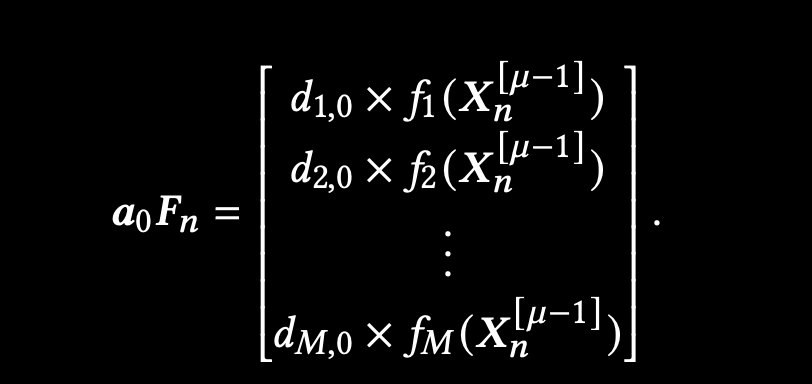

None
torch.Size([3, 384, 812])

Predicted formula:
 <S> \begin{array} { c c c } { a _ { 0 } F _ { n } = } \\ { d _ { 2 , 0 } \times f _ { 2 } ( X _ { n } ^ { [ \mu - 1 ] } ) } \\ \end{array} <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(100, 600, 3)


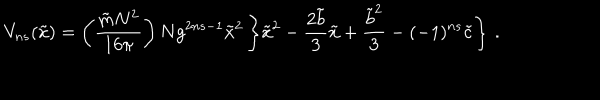

None
torch.Size([3, 100, 600])

Predicted formula:
 <S> \begin{array} { c c } { \chi _ { n } ( \hat { \zeta } ) = ( \frac { \hat { \zeta } \lambda ^ { 2 } } { \Gamma } ) \times 3 ^ { 2 n s s - 1 } \hat { \zeta } + \frac { 2 } { 2 } \hat { \zeta } + \frac { 2 } { 2 } - ( 7 - 7 ) ^ { \infty s } \hat { \zeta } ) ~ . } \\ { \cdots } \\ \end{array} <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(100, 600, 3)


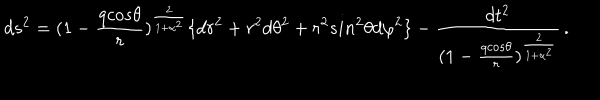

None
torch.Size([3, 100, 600])

Predicted formula:
 <S> \begin{array} { c c c } { \mathrm { d e } ^ { 2 } = ( 1 - \frac { 4 8 8 3 } { 3 } ) ^ { \frac { 1 } { 4 8 } } \langle 4 6 ^ { 2 } + \gamma ^ { 2 } 5 / n ^ { 2 } 8 4 8 \psi ^ { 2 } \} - \frac { 8 e ^ { 2 } } { \sqrt { 1 6 } } \sqrt { 1 6 } \psi ^ { 2 } \} - \frac { 1 } { 8 4 } } { \sqrt { 1 6 } } \sqrt { 1 6 } } , } \\ { \cdots , \cdots , \cdots , \cdots , \cdots , \cdots , \cdots , \cdots , \cdots , \cdots , \cdots , \cdots , \cdots


<IPython.core.display.Math object>

None
(224, 1020, 3)


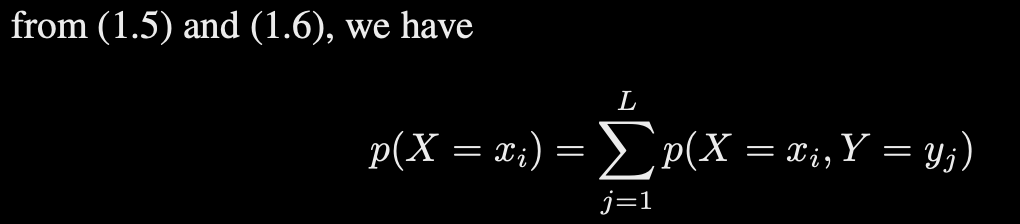

None
torch.Size([3, 224, 1020])

Predicted formula:
 <S> \mathrm { f r o m } \left( 1 , \Im \right) \mathrm { a n d } \left( 1 , 0 \right) , \mathrm { w e ~ h a v e } } <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 3264, 3)


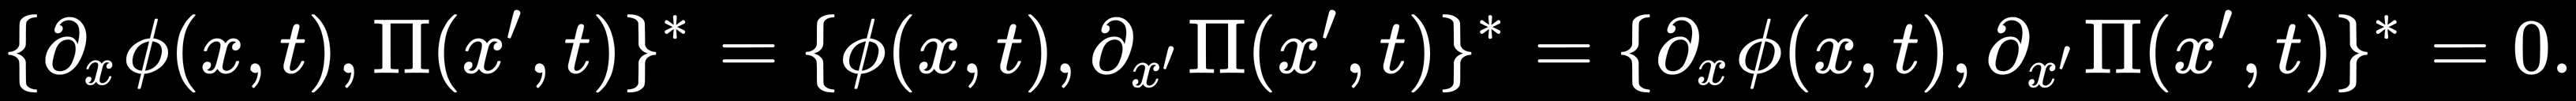

None
torch.Size([3, 128, 3264])

Predicted formula:
 <S> \{ \partial _ { x } \phi ( x , t ) , \Pi ( x ^ { \prime } , t ) \} ^ { * } = \{ \phi ( x , t ) \} ^ { * } = \{ \phi ( x , t ) \} ^ { * } = 0 . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 4042, 3)


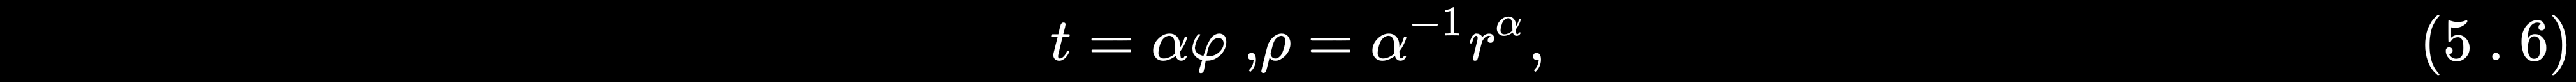

None
torch.Size([3, 128, 4042])

Predicted formula:
 <S> t = \alpha \varphi \; , \rho = \alpha \varphi \; , <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 9794, 3)


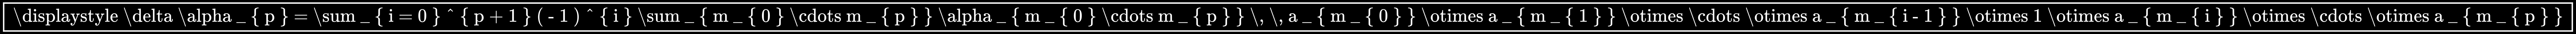

None
torch.Size([3, 128, 9794])

Predicted formula:
 <S> \fbox { \displaystyle { \displaystyle { \displaystyle { \sum _ { k = 1 } } } } } } } } { \displaystyle { \displaystyle { \sum _ { k = 1 } } } } } } } { \displaystyle { \displaystyle { \frac { \displaystyle { \displaystyle { m e l e l o n } } } } } } } } } } } } } <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


In [11]:
for image in IMAGES:
    predict_simple(image)

(128, 556, 3)


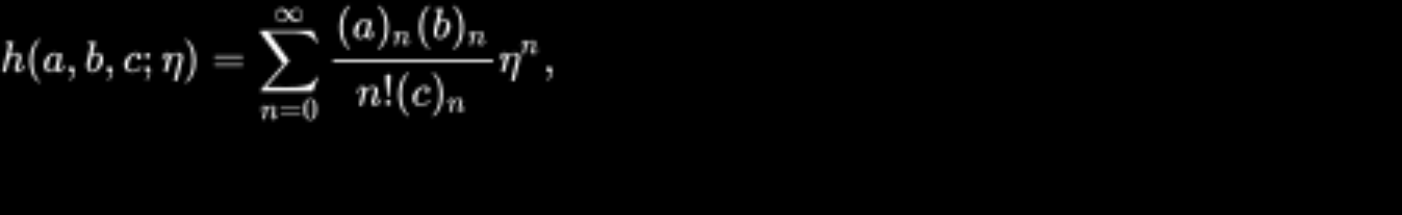

None
torch.Size([1, 215, 1402])

Predicted formula:
 <S> h ( { \bf a } , b , \, { \bf c } ; \, { \bf q } ) \equiv \sum _ { \bf n = 0 } ^ { \infty } \frac { ( { \bf a } ) _ { \bf n } } ( b ) _ { \bf n } } { \bf n ! ( { \bf e } ) _ { \bf n } } \eta ^ { \bf n } , <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 569, 3)


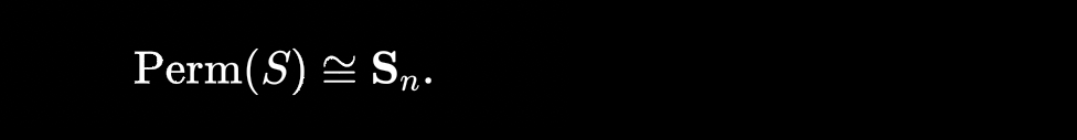

None
torch.Size([1, 140, 1077])

Predicted formula:
 <S> \mathrm { P e r m } ( S ) \cong { \bf S } _ { n } . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 485, 3)


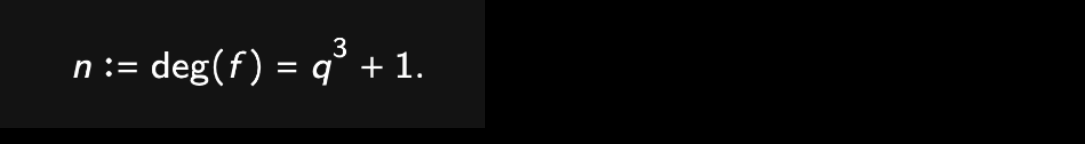

None
torch.Size([1, 144, 1085])

Predicted formula:
 <S> n : = \mathrm { d e g } ( f ) = q ^ { 3 } + 1 . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 554, 3)


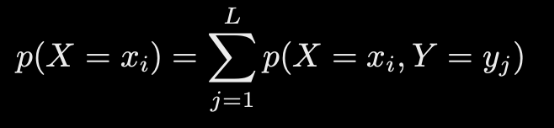

None
torch.Size([1, 128, 554])

Predicted formula:
 <S> p ( X = x _ { i } ) = \sum _ { j = 1 } ^ { L } p ( X = x _ { i } , Y = y _ { j } ) <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 432, 3)


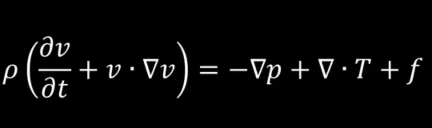

None
torch.Size([1, 128, 432])

Predicted formula:
 <S> \rho \left( \frac { \partial v } { \partial t } + v \cdot \nabla v \right) = - \nabla p + \nabla \cdot T + f \, . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 911, 3)


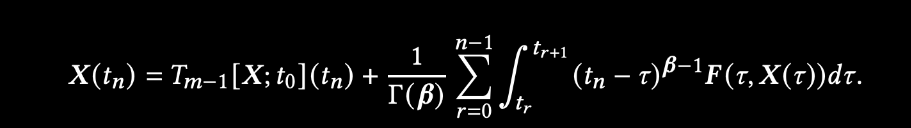

None
torch.Size([1, 128, 911])

Predicted formula:
 <S> X ( t _ { n } ) = T _ { m - 1 } [ X ; t _ { 0 } ] ( t _ { n } ) + \frac { 1 } { \Gamma ( \beta ) } \sum _ { r = 0 } ^ { n - 1 } \int _ { t _ { r } } ^ { t _ { r + 1 } } ( t _ { n } - \tau ) ^ { \beta - 1 } F ( \tau , X ( \tau ) ) d \tau . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 1328, 3)


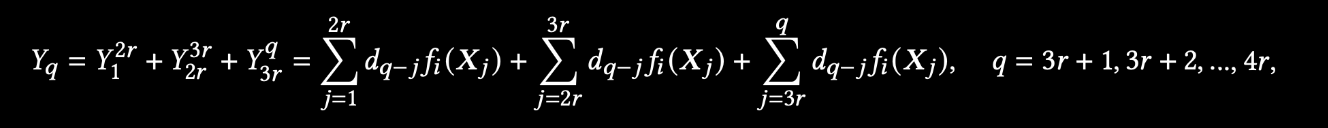

None
torch.Size([1, 128, 1328])

Predicted formula:
 <S> Y _ { q } = Y _ { 1 } ^ { 2 r } + Y _ { 2 r } ^ { 3 r } + Y _ { 3 r } ^ { q } = \sum _ { j = 1 } ^ { 2 r } d _ { q - j f } ( X _ { j } ) + \sum _ { j = 2 r } ^ { 3 r } d _ { q - j f } ( X _ { j } ) + \sum _ { j = N } ^ { q } d _ { q - j f i } ( X _ { j } ) , \quad q = 3 r + 1 , 3 r _ { j } ( X _ { j } ) , \quad q = 2


<IPython.core.display.Math object>

None
(128, 1124, 3)


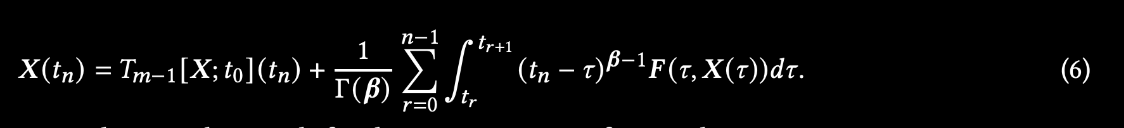

None
torch.Size([1, 128, 1124])

Predicted formula:
 <S> X ( t _ { n } ) = T _ { m - 1 } [ X ; t _ { 0 } ] ( t _ { n } ) \star \frac { 1 } { \Gamma ( \beta ) } \sum _ { r = 0 } ^ { n - 1 } \int _ { t _ { r } } ^ { t _ { r + 1 } } ( t _ { n } - \tau ) ^ { \beta - 1 } F ( \tau , X ( \tau ) ) d \tau . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 271, 3)


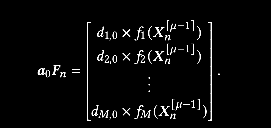

None
torch.Size([1, 128, 271])

Predicted formula:
 <S> a _ { i } F _ { i } \equiv \left[ \begin{array} { c c } { d _ { i j } \times K _ { i j } ( X _ { i j } ^ { \mu \nu - 1 } ) } \\ { d _ { i j } \times K _ { i j } ^ { \mu \nu - 1 } ) } \\ { d _ { i j } \times K _ { i j } ^ { \mu \nu - 1 } ) } \\ { d _ { i j } \times K _ { i j } ^ { \mu \nu - 1 } ) } \\ { d _ { i j } \times K _ { i j } ^ { \mu \nu - 1 } \right\} } \\ \end{array} <E> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 583, 3)


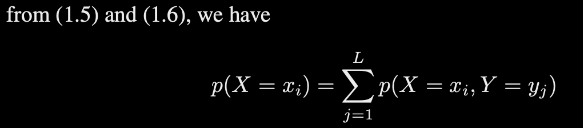

None
torch.Size([1, 128, 583])

Predicted formula:
 <S> \begin{array} { l l } { \mathrm { f o m ~ ( 1 , 5 ) ~ a n d ~ ( 1 , 5 ) ~ w e ~ } } \\ { p ( X = x _ { i } ) = \sum _ { j = 1 } ^ { L } p ( X = x _ { i } , Y = y _ { j } ) } \\ \end{array} <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 768, 3)


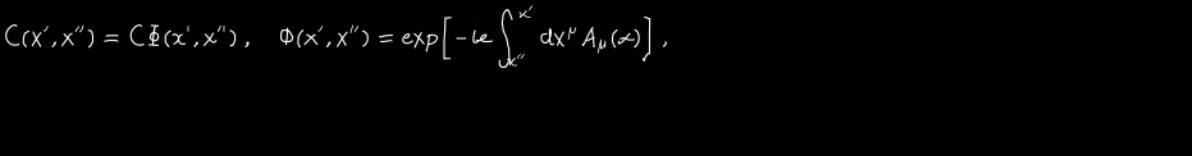

None
torch.Size([1, 156, 1192])

Predicted formula:
 <S> \zeta _ { C } \chi ^ { \prime } \star \chi ^ { \prime } ) = \subset \Phi ( \chi ^ { * } \star \chi ^ { \prime \prime } ) \, , \quad \quad \Theta ( \chi ^ { * } \star \chi ^ { \prime } \wedge A _ { \mu } ( \varphi ) \, . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 228, 3)


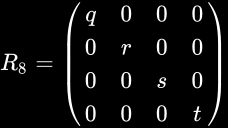

None
torch.Size([1, 128, 228])

Predicted formula:
 <S> R _ { 8 } = \left( \begin{array} { c c c c c } { q } & { 0 } & { 0 } & { 0 } \\ { 0 } & { r } & { 0 } & { 0 } \\ { 0 } & { 0 } & { s } & { 0 } \\ { 0 } & { 0 } & { s } & { 0 } \\ { 0 } & { 0 } & { 0 } & { t } \\ \end{array} \right) } \\ { 0 } & { 0 } & { 0 } & { t } \\ \end{array} \right) <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 3260, 3)


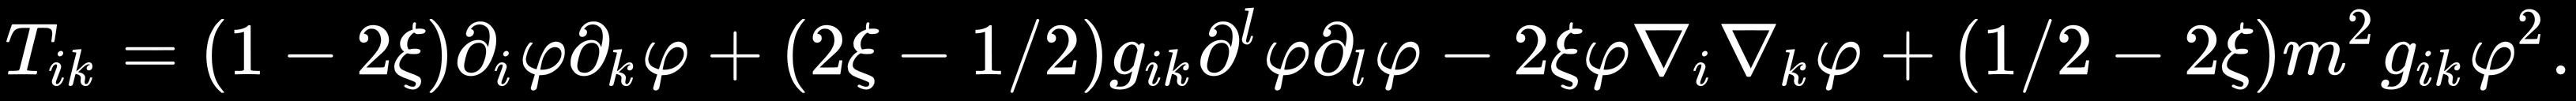

None
torch.Size([1, 128, 3260])

Predicted formula:
 <S> T _ { i k } = ( 1 - 2 \xi ) \partial _ { i } \varphi \partial _ { k } \varphi + ( 2 \xi + ( 2 \xi + ( 2 \xi + ) <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 727, 3)


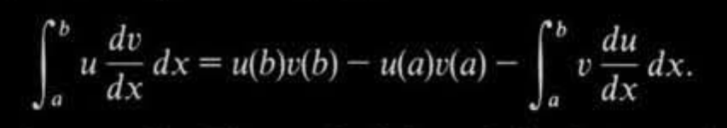

None
torch.Size([1, 128, 727])

Predicted formula:
 <S> \int _ { a } ^ { b } u \frac { d v } { d \chi } \, d \chi = u ( b \hat { v } ( b ) - u ( d ) v ( \hat { u } ) - \int _ { a } ^ { b } v \frac { d u } { d \chi } d \chi . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 950, 3)


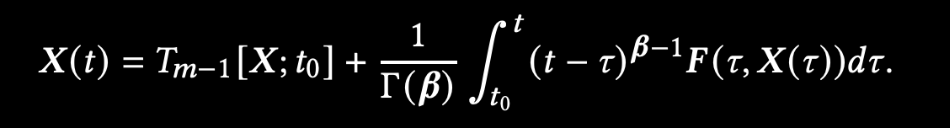

None
torch.Size([1, 128, 950])

Predicted formula:
 <S> X ( t ) = T _ { m - 1 } [ X ; t _ { 0 } ] + \frac { 1 } { \Gamma ( \beta ) } \int _ { t _ { 0 } } ^ { t } ( t - \tau ) ^ { \beta - 1 } F ( \tau , X ( \tau ) ) d \tau . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 271, 3)


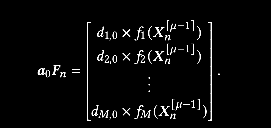

None
torch.Size([1, 128, 271])

Predicted formula:
 <S> a _ { i } F _ { i } \equiv \left[ \begin{array} { c c } { d _ { i j } \times K _ { i j } ( X _ { i j } ^ { \mu \nu - 1 } ) } \\ { d _ { i j } \times K _ { i j } ^ { \mu \nu - 1 } ) } \\ { d _ { i j } \times K _ { i j } ^ { \mu \nu - 1 } ) } \\ { d _ { i j } \times K _ { i j } ^ { \mu \nu - 1 } ) } \\ { d _ { i j } \times K _ { i j } ^ { \mu \nu - 1 } \right\} } \\ \end{array} <E> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 768, 3)


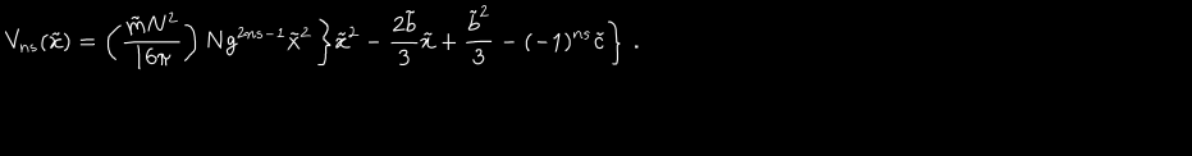

None
torch.Size([1, 156, 1192])

Predicted formula:
 <S> \chi _ { \gamma * } ( \widetilde { \cal K } ) = \left( \begin{array} { c c } { \widetilde { \Gamma } \lambda ^ { 2 \gamma - 1 } \widetilde { \kappa } ^ { 2 } \right\} \widetilde { \cal K } ^ { - } - \frac { 2 5 } { 2 } \widetilde { \kappa } + \frac { E ^ { 2 } } { 3 } - \left( - 7 \right) ^ { \gamma \alpha } \widetilde { \varepsilon } \right\} \, . } \\ { } \\ { . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . <E> <P> <P>


<IPython.core.display.Math object>

None
(128, 768, 3)


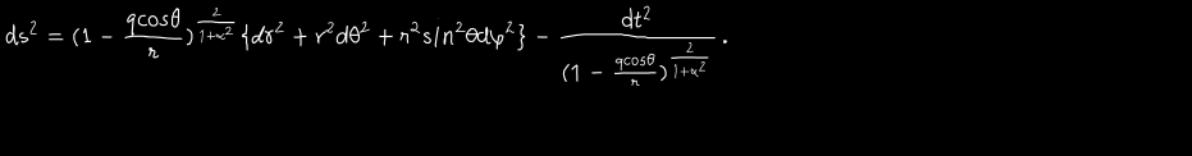

None
torch.Size([1, 156, 1192])

Predicted formula:
 <S> \mathrm { d s } z ^ { \prime } = ( 1 - \frac { 7 \infty s \theta } { \hbar } \sqrt { \frac { k \omega } { i \omega ^ { 2 } } } \, \langle \phi G ^ { 2 } + \gamma ^ { 2 } s t h \varphi ^ { 2 } 3 - \frac { \mathrm { d e s } ^ { 2 } } { \sqrt { 1 + \infty } ^ { 2 } } } } . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 583, 3)


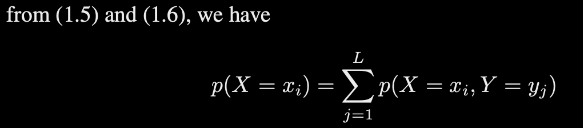

None
torch.Size([1, 128, 583])

Predicted formula:
 <S> \begin{array} { l l } { \mathrm { f o m ~ ( 1 , 5 ) ~ a n d ~ ( 1 , 5 ) ~ w e ~ } } \\ { p ( X = x _ { i } ) = \sum _ { j = 1 } ^ { L } p ( X = x _ { i } , Y = y _ { j } ) } \\ \end{array} <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 3264, 3)


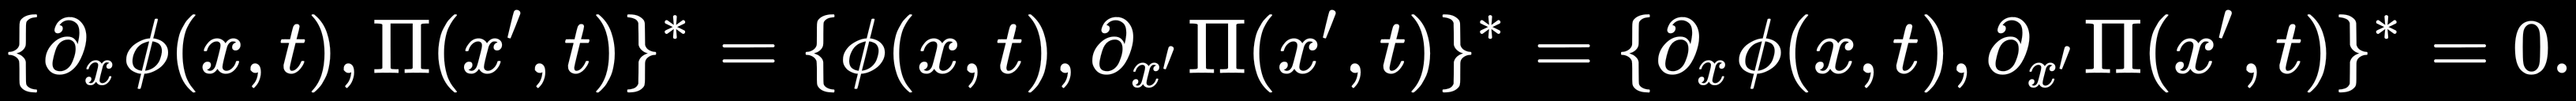

None
torch.Size([1, 128, 3264])

Predicted formula:
 <S> \{ \partial _ { x } \phi ( x , t ) , \Pi ( x ^ { \prime } , t ) \} ^ { * } = \{ \phi ( x , t ) \} ^ { * } = \{ \phi ( x , t ) \} ^ { * } = 0 . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 4042, 3)


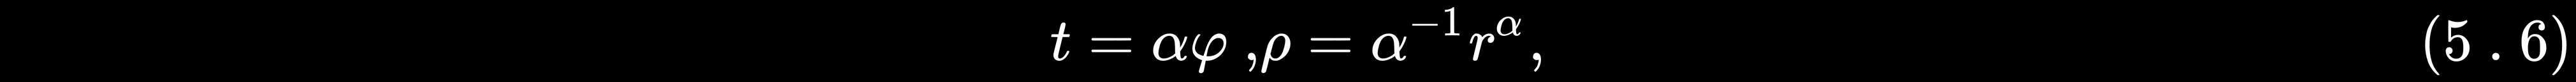

None
torch.Size([1, 128, 4042])

Predicted formula:
 <S> t = \alpha \varphi \; , \rho = \alpha \varphi \; , <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 9794, 3)


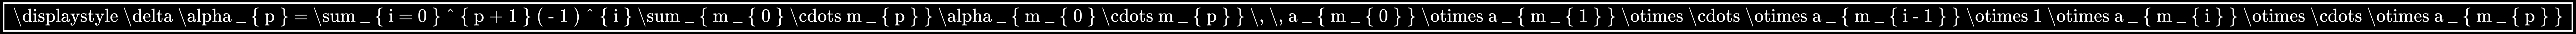

None
torch.Size([1, 128, 9794])

Predicted formula:
 <S> \fbox { \displaystyle { \displaystyle { \displaystyle { \sum _ { k = 1 } } } } } } } } { \displaystyle { \displaystyle { \sum _ { k = 1 } } } } } } } { \displaystyle { \displaystyle { \frac { \displaystyle { \displaystyle { m e l e l o n } } } } } } } } } } } } } <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


In [14]:
for image in IMAGES:
    predict_scaled(image)